<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [3]:
import pandas as pd
import psycopg2
import warnings

In [4]:
#отключим предупреждения
warnings.filterwarnings('ignore', category=UserWarning, message= 'pandas only supports SQLAlchemy connectable.*')

In [6]:
#установим соединение с базой данных
connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [7]:
table = 'vacancies'
query_3_1 = f'''select count(id)
                from public.{table}
            '''

In [8]:
df = pd.read_sql_query(query_3_1, connection)
count_vacancies = df['count'].iloc[0]
print(f'В базе хранится информация о {count_vacancies} вакансиях')

В базе хранится информация о 49197 вакансиях


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [9]:
table = 'employers'
query_3_2 = f'''select count(id)
                from public.{table}
            '''

In [10]:
df = pd.read_sql_query(query_3_2, connection)
count_employers = df['count'].iloc[0]
print(f'В базе представлена информация о {count_employers} работодателе')

В базе представлена информация о 23501 работодателе


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [11]:
table = 'areas'
query_3_3 = f'''select count(id)
                from public.{table}
            '''

In [12]:
df = pd.read_sql_query(query_3_3, connection)
count_areas = df['count'].iloc[0]
print(f'В базе представлена информация о {count_areas} регионах')

В базе представлена информация о 1362 регионах


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [13]:
table = 'industries'
query_3_4 = f'''select count(id)
                from public.{table}
            '''

In [14]:
df = pd.read_sql_query(query_3_4, connection)
count_industries = df['count'].iloc[0]
print(f'В базе представлена информация о {count_industries} сферах деятельности')

В базе представлена информация о 294 сферах деятельности


***

**Выводы по предварительному анализу**
___
В соответствии с полученной информацией из базы данных удалось определить основные размерности:

- В базе хранится информация о **49197** вакансиях;
- В базе представлена информация о **23501** работодателе;
- В базе представлена информация о **1362** регионах;
- В базе представлена информация о **294** сферах деятельности

На каждую сферу деятельности в среднем приходится **80** работодателей.
В среднем в каждом регионе **17** работодателей.
В среденем у каждого работодателя открыто по **2** вакансии.
В среднем на каждую сферу деятельности открыто **160** вакансий.

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [15]:
#установим лимит
n = 5
#объединим `vacancies` и `areas` по area_id, сгруппируем и посчитаем
query_4_1 = f'''select
                        ar.name area,
                        count(vac.id) cnt
                from public.vacancies vac
                join public.areas ar on vac.area_id = ar.id
                group by ar.id
                order by 2 desc
                limit {n}
                '''

In [16]:
df = pd.read_sql_query(query_4_1, connection)
print('Топ 5 в регионов по количеству вакансий:')
display(df)

Топ 5 в регионов по количеству вакансий:


,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [17]:
query_4_2 = f'''select
                        count(id)
                from public.vacancies
                where (salary_from is not null) or (salary_to is not null)
                '''

In [18]:
df = pd.read_sql_query(query_4_2, connection)
count_salary_vacancies = df['count'].iloc[0]
print(f'Из {count_vacancies} представленных вакансий информация о заработной плате указана у {count_salary_vacancies}')

Из 49197 представленных вакансий информация о заработной плате указана у 24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [19]:
#для округления приведем значения к целочисленному типу
query_4_3 = f'''select
                        avg(salary_from)::int avg_slr_from,
                        avg(salary_to)::int avg_slr_to
                from public.vacancies
                '''

In [20]:
df = pd.read_sql_query(query_4_3, connection)
avg_slr_from = df['avg_slr_from'].iloc[0]
avg_slr_to = df['avg_slr_to'].iloc[0]
print(f'В среднем зарплаты варьируются в интервале от {avg_slr_from} до {avg_slr_to} руб.')

В среднем зарплаты варьируются в интервале от 71065 до 110537 руб.


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [21]:
#зададим параметры смешения и лимита
offs = 0
lim = 10
#создадим новый признак, сгруппируем по нему и посчитаем
query_4_4 = f'''select
                        schedule||'-'||employment as type,
                        count(id) cnt
                from public.vacancies
                group by type
                order by cnt desc
                offset {offs}
                limit {lim}
                '''

In [22]:
df = pd.read_sql_query(query_4_4, connection)
print('Топ 10 сочетаний типов рабочего графика и трудоустройства:')
display(df)

Топ 10 сочетаний типов рабочего графика и трудоустройства:


,type,cnt
0,Полный день-Полная занятость,35367
1,Удаленная работа-Полная занятость,7802
2,Гибкий график-Полная занятость,1593
3,Удаленная работа-Частичная занятость,1312
4,Сменный график-Полная занятость,940
5,Полный день-Стажировка,569
6,Вахтовый метод-Полная занятость,367
7,Полный день-Частичная занятость,347
8,Гибкий график-Частичная занятость,312
9,Полный день-Проектная работа,141


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [23]:
query_4_5 = f'''select
                        experience,
                        count(id) cnt
                from public.vacancies
                where experience is not null
                group by experience
                order by cnt asc
                '''

In [24]:
df = pd.read_sql_query(query_4_5, connection)
print('Информация о требуемом опыте в представленных вакансиях (по количеству вакансий в порядке возрастания)')
display(df)

Информация о требуемом опыте в представленных вакансиях (по количеству вакансий в порядке возрастания)


,experience,cnt
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

**Выводы по детальному анализу**
___

Наибольшее количество вакансий открыто в **больших** городах. Больше половины имеющихся вакансий **не содержат** информацию о заработной плате.\
Определены средние нижняя и верхняя границы заработных плат, однако интереснее было бы посмотреть на распределение медианных зарплат в разрезе регионов и работодателей.\
Большинсто вакансий ищут работников на **полный рабочий день** и **полную занятость**. На втором месте вакансии предлагают **удаленную работу**.
В большинсте вакансий требуется опыт работы **от 1 до 3 лет**. Не на последнем месте по количеству вакансий **опыт работы не требуется**.

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [25]:
lim = 5
#объединим `vacancies` и `employers` и посчитаем вакансии по работодателям. Выведем топ `lim`
query_5_1 = f'''select
                        empl.name employers,
                        count(vac.id) cnt
                from public.vacancies vac
                join public.employers empl on empl.id = vac.employer_id
                group by empl.name
                order by cnt desc
                limit {lim}
                '''

In [26]:
db = pd.read_sql_query(query_5_1, connection)
first_employer = db['employers'].iloc[0]
fifth_employer = db['employers'].iloc[4]
print(f'Первое место среди работодателей по количеству вакансий занимает {first_employer}')
print(f'На пятом месте - {fifth_employer}')

Первое место среди работодателей по количеству вакансий занимает Яндекс
На пятом месте - Газпром нефть


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [27]:
lim = 1
#объединим `areas` с `vacancies` и `employers` и отфильтруем по пустым вакансиям
#сгруппируем по регионам и посчитаем работодателей. настроим вывод `lim`
query_5_2 = f'''select
                     area.name area,
                     count(distinct empl.id) cnt_employers,
                     count(distinct vac.id) cnt_vacancies   
               from public.areas area
               left join public.vacancies vac on vac.area_id = area.id
               left join public.employers empl on area.id = empl.area
               where vac.id is null
               group by area.name
               order by cnt_employers desc
               limit {lim}
               '''

In [28]:
db = pd.read_sql_query(query_5_2, connection)
area_empl_vac = db['area'].iloc[0]
print(f'Регион в котором больше всего работодателей, но нет вакансий: {area_empl_vac}')

Регион в котором больше всего работодателей, но нет вакансий: Россия


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [29]:
query_5_3 = f'''select
                     count(distinct area_id) areas
                from public.vacancies     
                group by employer_id
                order by 1 desc
                limit 5
                '''

In [30]:
db = pd.read_sql_query(query_5_3, connection)
display(db)

,areas
0,181
1,152
2,116
3,88
4,71


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [31]:
#объединим `employers` и `employers_industries`, отфильтруем и посчитаем
query_5_4 = f"""select
                count(empl.id)
                from public.employers empl
                left join public.employers_industries ind on empl.id = ind.employer_id
                where ind.industry_id is null
                """

In [32]:
df = pd.read_sql_query(query_5_4, connection)
count_employers_wo_ind = df['count'].iloc[0]
print(f"У {count_employers_wo_ind} работодателей не указана сфера деятельности")

У 8419 работодателей не указана сфера деятельности


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [33]:
place = 3           #параметр места (смещение)
count_ind = 4       #параметр количества сфер деятельности

# для рассчета объединим `employers` и `employers_industries`
query_5_5 = f"""select
                empl.name
                from public.employers empl
                join public.employers_industries ind on empl.id = ind.employer_id
                group by empl.id
                having count(ind.industry_id) = {count_ind}
                order by 1
                limit 1
                offset {place}-1
                """

In [34]:
df = pd.read_sql_query(query_5_5, connection)
company_name_ind = df['name'].iloc[0]
print(f'Среди компаний, у которых указано {count_ind} сферы деятельности, на {place}-м месте находится {company_name_ind}')

Среди компаний, у которых указано 4 сферы деятельности, на 3-м месте находится 2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [35]:
# для подсчета количества объединим `industries` и `employers_industries`
query_5_6 = f"""select
                count(distinct empl.employer_id)
                from public.industries ind
                join public.employers_industries empl on ind.id = empl.industry_id
                where ind.name = 'Разработка программного обеспечения'                
                """

In [36]:
df = pd.read_sql_query(query_5_6, connection)
count_employers_w_ind = df['count'].iloc[0]
print(f'У {count_employers_w_ind} работодателей в качестве сферы деятельности указана Разработка программного обеспечения.')

У 3553 работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [37]:
# Импортируем необходимые библиотеки
import requests as requests
from bs4 import BeautifulSoup

url = 'https://ru.wikipedia.org/wiki/Города-миллионеры_России'      #Веб источник
response = requests.get(url, headers={'User-Agent':'Mozila 6.0'})   #Получим данные страницы с агентом
page = BeautifulSoup(response.text, 'html.parser')                  #Представим страницу с использованием класса BS

In [38]:
#Пропарсим страницу 
cities = []                                                         #Пустой список городов
table = page.find_all('table',{'class':'standard sortable'})[0]     #Строка всех таблиц
for row in table.find_all('tr'):                                    #Список с разбивкой по tr
    cell = row.find_all('td')                                       #Список с разбивкой по td
    if len(cell)>1:                                                 #Отсекаем пустой список
        cities.append(cell[1].text)                                 #Забираем текст 2-го элемента в список
display(cities)

['Москва',
 'Санкт-Петербург',
 'Новосибирск',
 'Екатеринбург',
 'Казань',
 'Красноярск',
 'Нижний Новгород',
 'Челябинск',
 'Уфа',
 'Краснодар',
 'Самара',
 'Ростов-на-Дону',
 'Омск',
 'Воронеж',
 'Пермь',
 'Волгоград']

In [39]:
company = "Яндекс"      #параметр с названием компании

#для рассчета используем `vacancies`, `employers` и `areas`
#для фильтрации используем параметр с названием компании а также кортеж городов-милионников
#объединим с расчетов общего количества вакансий
query_5_7 = f"""(select
                ar.name as area,
                count(vac.id) as cnt
                from public.vacancies vac
                join public.employers empl on vac.employer_id = empl.id
                join public.areas ar on vac.area_id = ar.id
                where  (empl.name = '{company}') and (ar.name in {tuple(cities)})
                group by ar.id)
                
                union all
                
                (select
                'Total',
                count(vac.id) as cnt
                from public.vacancies vac
                join public.employers empl on vac.employer_id = empl.id
                join public.areas ar on vac.area_id = ar.id
                where  (empl.name = '{company}') and (ar.name in {tuple(cities)}))
                
                order by cnt asc
                """

In [40]:
df = pd.read_sql_query(query_5_7, connection)
print(f'В выгрузке присутствует {df.shape[0]} строк')
total = df[df['area']=='Total']['cnt'].iloc[0]
print(f'У Яндекса в городах-миллионниках опубликовано {total} вакансий')
display(df)

В выгрузке присутствует 17 строк
У Яндекса в городах-миллионниках опубликовано 485 вакансий


,area,cnt
0,Омск,21
1,Челябинск,22
2,Красноярск,23
3,Волгоград,24
4,Пермь,25
5,Казань,25
6,Ростов-на-Дону,25
7,Самара,26
8,Уфа,26
9,Краснодар,30


***

**Выводы**:
- в топ-5 работадателей по количеству вакансий занимает **ИТ** и **нефтегазовая промышленность** (Яндекс -> Газпром нефть);
- среди регионов определён регион, в котором отсутствую вакансии - Россия. Это может быть связано с тем, что работодатели конкретизируют регион, в котором размещают вакансии;
- среди работодателей присутствует тот, что разместил вакансии в **181** регионе;
- из практически **24-х тысяч** работодателей у **8-ми тысяч** не указана сфера деятельности, причем присутствут те, кто указал несколько сфер деятельности сразу.
- у **15%** работодателей в качестве сферы деятельности указана "разработка программного обеспечения", что свидетельствует о нехватке кадров в данной сфере.

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [41]:
query_6_1 = f"""select
                count(id)
                from public.vacancies
                where (lower(name) like '%data%') or (lower(name) like '%данн%')
                """

In [42]:
df = pd.read_sql_query(query_6_1, connection)
count_vac_data=df['count'].iloc[0]
print(f'{count_vac_data} вакансий имеет отношение к данным')

1771 вакансий имеет отношение к данным


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [43]:
#настроим отдельный фильтр по вакансиям для дата-сайентистов
#используем сравнение с '%ML%' в верхнем регистре для исключения из выборки 'TeamLead'
vac_data_list = f"""
                    (lower(name) like '%data scientist%' or
                    lower(name) like '%data science%' or
                    lower(name) like '%исследователь данных%' or
                    (name like '%ML%' and
                    name not ilike '%html%') or
                    lower(name) like '%machine learning%' or
                    lower(name) like '%машинн%обучен%')
                    """

#применим фильтр в запросе, не забываем приводить к нижнему регистру
query_6_2 = f"""select
                count(id)
                from public.vacancies
                where 
                {vac_data_list} and 
                (lower(name) like '%junior%' or
                lower(experience) like '%нет опыта%' or
                lower(employment) like '%стажировка%')
                """

In [44]:
df = pd.read_sql_query(query_6_2, connection)
count_vac_junior = df['count'].iloc[0]
print(f'Для начинающего дата-сайентиста представлено {count_vac_junior} вакансия')

Для начинающего дата-сайентиста представлено 51 вакансия


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [45]:
#применим ранее настроенный фильтр
query_6_3 = f"""select
                count(id)
                from public.vacancies
                where 
                {vac_data_list} and 
                (key_skills like '%SQL%' or
                lower(key_skills) like '%postgres%')
                """

In [46]:
df = pd.read_sql_query(query_6_3, connection)
count_vac_ds = df['count'].iloc[0]
print(f'У {count_vac_ds} вакансий в качестве ключевых навыков указан SQL')

У 201 вакансий в качестве ключевых навыков указан SQL


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [47]:
query_6_4 = f"""select
                count(id)
                from public.vacancies
                where
                {vac_data_list} and
                lower(key_skills) like '%python%'
                """

In [48]:
df = pd.read_sql_query(query_6_4, connection)
count_vac_py = df['count'].iloc[0]
print(f'У {count_vac_py} вакансий в качестве ключевого навыка указан Python')

У 351 вакансий в качестве ключевого навыка указан Python


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [49]:
#можно выгрузить строку с ключевыми навыками в data frame, разбить на список и посчитать его длину
#для выгрузки количества навыков в sql запросе посчитаем количество разделителей и увеличим на 1
query_6_5 = f"""select
                round(avg(length(key_skills)-length(replace(key_skills, '\t',''))+1),2) count
                from public.vacancies
                where {vac_data_list}
                """

In [50]:
df = pd.read_sql_query(query_6_5, connection)
count_vac_avg_ds = df['count'].iloc[0]
print(f'В среднем в вакансиях для DS указывают {count_vac_avg_ds} ключевых навыков')

В среднем в вакансиях для DS указывают 6.41 ключевых навыков


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [51]:
#посчитаем среднюю з/п, используя coalesce с тремя входными данными
query_6_6 = f"""select
                experience exp,
                round(avg (coalesce((salary_from + salary_to)/2, salary_from, salary_to)),0) avg_salary
                from public.vacancies
                where {vac_data_list} and
                (salary_from is not null or salary_to is not null)
                group by experience
                """

In [52]:
df = pd.read_sql_query(query_6_6, connection)
avg_salary_ds = df[df['exp']=='От 3 до 6 лет']['avg_salary'].iloc[0]
print(f'Дата-сайентист с опытом работы от 3 до 6 лет может рассчитывать на зарплату: {int(avg_salary_ds)}')

Дата-сайентист с опытом работы от 3 до 6 лет может рассчитывать на зарплату: 243115


***

**Выводы**:
В ходе анализа на востребованность дата-сайентистов выявлено:
- на данную профессию имеется достаточный спрос, порядка **5%**;
- востребованы не только дата-сайентисты с опытом, но и **начинающие**;
- среди основных навыков востребованы как **Python**, так и умение работать с базами данных (**SQL, Postgress**);
- опыт работы сильно **влияет** на уровень заработной платы;
- для дата-сайентиста требуется в среднем **6** ключевых навыков.

# Общий вывод по проекту

В соответствии с первоначально поставленной задачей требуется определить, насколько хранящиеся данные в базе подходят для формирования модели поиска вакансий для клиентов.

С учетом проведенного анализа наиболее важными критериями возможно выделить наличие **ключевых навыков**, приобретенных специалистом, **опыт работы**.
С учетом того, что многим специлиатам предлагают дистанционный формат работы _регион_ публикации вакансии _не имеет особо важного значения_, также _с учетом роста зарплаты_ с получением опыта уровень зарплаты для junior специалистов _не будет иметь критического значения_.

In [53]:
#посчитаем средние з/п в разрезе опыта работы и типа занятости
query_addit_1 = f"""select
                    round(avg(coalesce((salary_from + salary_to)/2, salary_from, salary_to)),2) avg_salary,
                    experience,
                    schedule
                    from public.vacancies
                    where {vac_data_list} and
                    (salary_from is not null or salary_to is not null)
                    group by experience, schedule
                    order by 2, 3
                    """

In [54]:
df_addit_1 = pd.read_sql_query(query_addit_1, connection)

In [55]:
#посчитаем количество вакансий в разрезе опыта работы и типа занятости
query_addit_2 = f"""select
                    count(id),
                    experience,
                    schedule
                    from public.vacancies
                    where {vac_data_list}
                    group by experience, schedule
                    order by 2, 3
                    """

In [56]:
df_addit_2 = pd.read_sql_query(query_addit_2, connection)

In [57]:
#импортируем библиотеки для визуализации
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

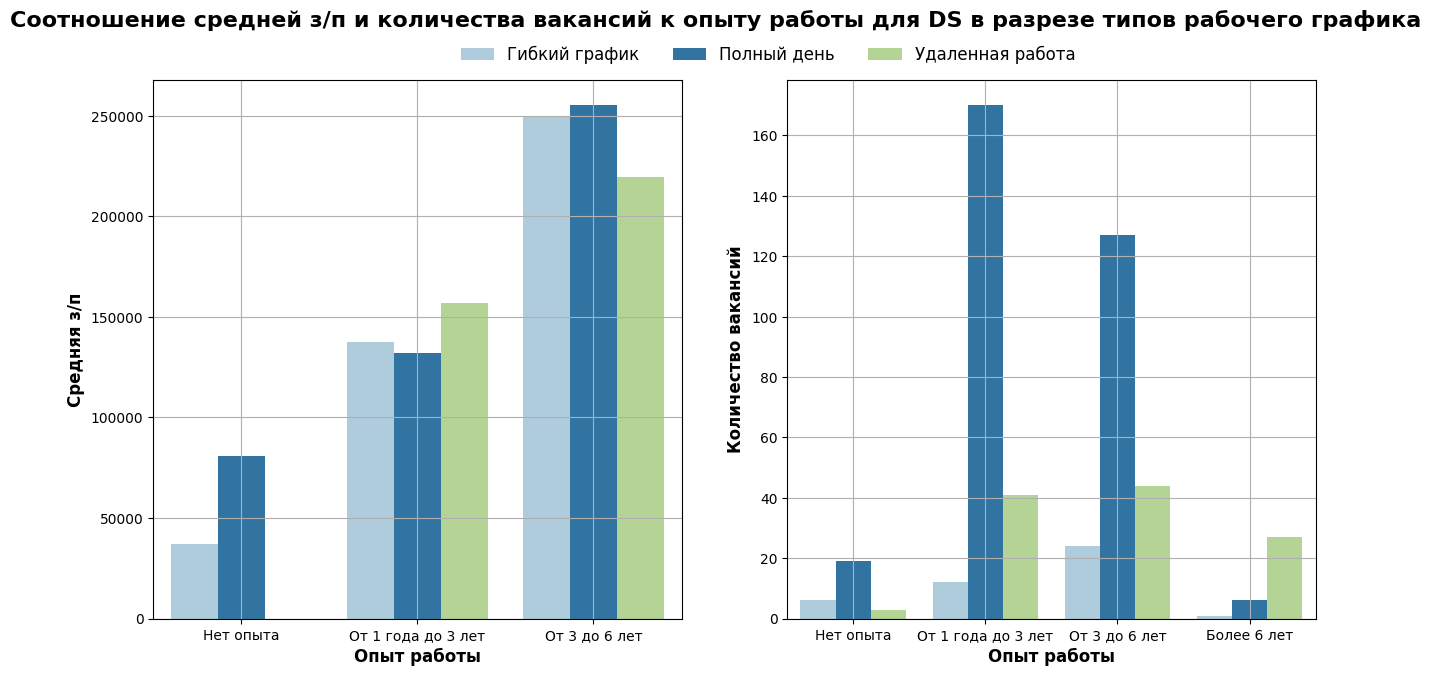

In [58]:
#построим сабплоты средних зарплат и количества вакансий
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.barplot(
    data = df_addit_1,
    x= 'experience',
    y= 'avg_salary',
    hue= 'schedule',
    palette= 'Paired',
    ax= axes[0]
)

sns.barplot(
    data = df_addit_2,
    x= 'experience',
    y= 'count',
    hue= 'schedule',
    palette= 'Paired',
    order= ['Нет опыта','От 1 года до 3 лет', 'От 3 до 6 лет', 'Более 6 лет'],
    legend= False,
    ax= axes[1]
)

#кастомизируем графики 
#сетка
axes[0].grid()
axes[1].grid()

#подписи осей
axes[0].set_ylabel('Средняя з/п', fontweight='bold', fontsize= 12)
axes[1].set_ylabel('Количество вакансий', fontweight='bold', fontsize= 12)
axes[0].set_xlabel('Опыт работы', fontweight='bold', fontsize= 12)
axes[1].set_xlabel('Опыт работы', fontweight='bold', fontsize= 12)

fig.suptitle('Соотношение средней з/п и количества вакансий к опыту работы для DS в разрезе типов рабочего графика',fontsize=16, fontweight='bold')

#легенда
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove()
fig.legend(handles=handles,labels=labels, title=None, bbox_to_anchor=(0.75,0.95), ncol=3, frameon=False, fontsize= 12);

- В соответствии с представленным графиком наблюдаем зависимость роста **заработной платы от опыта работы**, причем критерий `Тип графика` _не является ключевым_, т.к. отсутствует в вакансиях без опыта работы.
- Для вакансий с требованием `Более 6 лет` информация о заработной плате **отсутствует**, т.к. уровень заработной платы для данных специалистов обсуждается индивидуально по результатам собеседования. Соответственно построенная на имеющихся данных модель не сможет подобрать релевантную вакансию для сосискателей основываясь на его зарплатных ожиданиях.
- Больше всего работодатели ищут работников с опытом работы `От 1 года до 3` и на `Полный день`. Соотношение данных вакансий к вакансиям с _удаленным форматом работы_ составляет **4:1**.
- С увеличением опыта работы наблюдаем тенденцию к смещению соотношения типа графиков работ в сторону `Удаленной работы`, что может быть связано с ростом профессиональных навыков и самостоятельности у специалистов и уменьшением необходимости контроля выполнения их работы.

In [59]:
#выгрузим список усредненных зарплат для DS и остальных вакансий
query_addit_3 = f"""(select
                    round(coalesce((salary_from + salary_to)/2, salary_from, salary_to),2) salary,
                    experience,
                    'DataScience' as profession
                    from public.vacancies
                    where {vac_data_list} and
                    (salary_from is not null or salary_to is not null)
                    )
                    
                    union all
                    
                    (select
                    round(coalesce((salary_from + salary_to)/2, salary_from, salary_to),2) salary,
                    experience,
                    'Другие' as profession
                    from public.vacancies
                    where not ({vac_data_list}) and
                    (salary_from is not null or salary_to is not null)
                    )
                    order by 3, 2
                    """

In [60]:
df_addit_3= pd.read_sql(query_addit_3, connection)

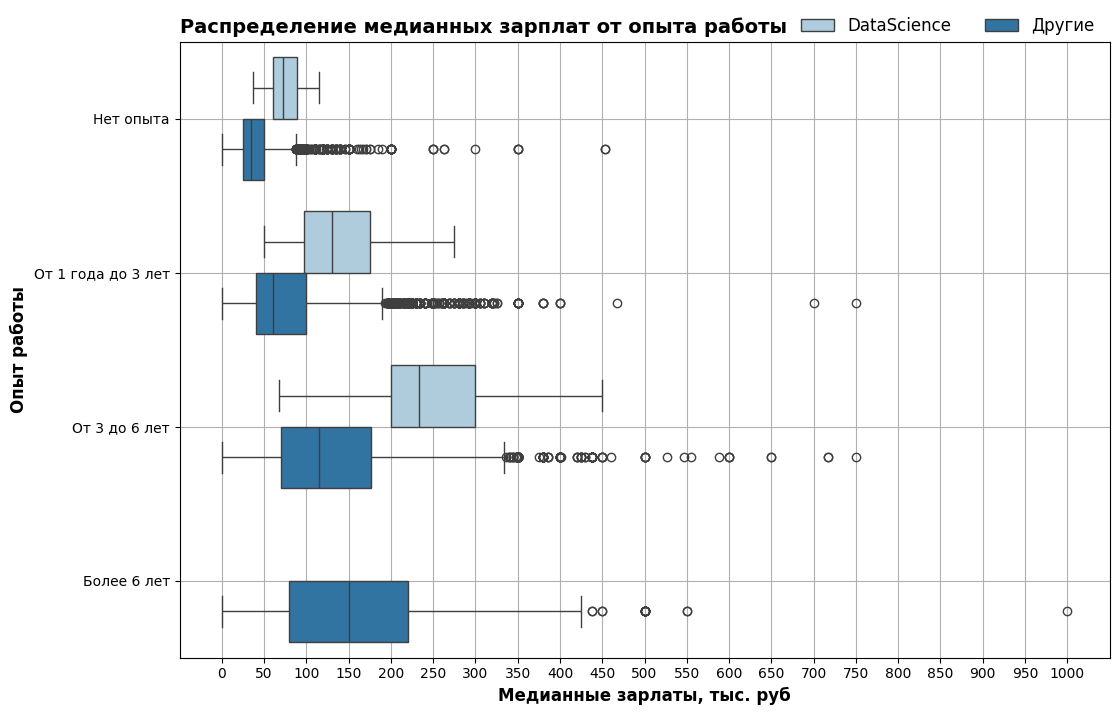

In [61]:
#переведем зарплаты в тыс. руб
df_plot = df_addit_3.copy()
df_plot['salary']=df_plot['salary'].apply(lambda x: x/1000)

#отрисуем коробчату диаграмму и сравним медианные зарплаты
fig = plt.figure(figsize=(12, 8))
boxplot= sns.boxplot(
    data= df_plot,
    x= 'salary',
    y= 'experience',
    hue= 'profession',
    orient='h',
    palette= 'Paired'
)

#кастомизация графика
#сетка
boxplot.grid()
boxplot.xaxis.set_major_locator(MultipleLocator(50))

boxplot.set_title('Распределение медианных зарплат от опыта работы', fontweight='bold', fontsize=14, loc='left');

#оси
boxplot.set_xlabel('Медианные зарлаты, тыс. руб', fontweight='bold', fontsize=12);
boxplot.set_ylabel('Опыт работы', fontweight='bold', fontsize=12);

#легенда
handles, labels = boxplot.get_legend_handles_labels()
boxplot.get_legend().remove()
fig.legend(handles=handles,labels=labels, title=None, bbox_to_anchor=(0.9,0.93), ncol=2, frameon=False, fontsize= 12);

Из представленного графика видим соотношение зарплат специалистов DS и остальных вакансий в разрезе опыта работы.\
_Медианные зарплаты_ специалистов DS в **2 раза выше** _медианных зарплат_ специалистов других профессий

____
В результате проведенного анализа возможно утверждать, что хранящеся данные **подходят** для формирования модели поиска вакансий для клиентов.

In [62]:
#Закроем соединение
connection.close()